In [1]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import scienceplots
plt.style.use(["science"])
from IPython.display import Video
import cv2

## Functions to process data
from cvfem.dynamics import track_object, pos_to_accel, plot_results

## Functions to analyze data with system identification
from mdof import sysid, modes, modal, predict

['/opt/homebrew/Caskroom/miniforge/base/envs/ce249/lib/python3.12/site-packages/ipykernel_launcher.py', '--f=/Users/cchern/Library/Jupyter/runtime/kernel-v3ce070329fb13cb73741c1aea110ea22882281329.json']


# Two-Story Building: Estimate a Linear System (video data)

## 1. Experimental Setup and Data Collection

<div>
<img src="../../uploads/setup_4.png" width="250"/>
</div>

### Collected Data

| Trial | Motion         | Amplitude (cm) | Frequency (Hz) | Samples per second (sps) | Filename                  |
|-------|----------------|----------------|----------------|--------------------------|---------------------------|
| A     | sine wave      | 2.0            | 2.0            | 120                      | Trial A: Sine Wave ...    |
| B     | sine wave      | 2.0            | 2.0            | 120                      | Trial B: Sine Wave ...    |
| C     | Northridge EQ  | N/A            | N/A            | 120                      | Trial C: Northridge ...   |

In [2]:
DATA_DIR = Path('../../uploads/mini_shake_table')
OUT_DIR = Path('out')
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

COLLECTED_DATA = {
    1 : ['sine wave',       2.0,   2.0,  120, "Sienna's Trials/Trial A: Sine Wave (2.0 Amplitude, 2.0 Frequency).MOV"],
    2 : ['sine wave',       2.0,   2.0,  120, "Sienna's Trials/Trial B: Sine Wave (2.0 Amplitude, 2.0 Frequency).MOV"],
    3 : ['Northridge',     None,  None,  120, "Sienna's Trials/Trial C: Northridge earthquake.MOV"],
}

### Sine wave with amplitude of 2.0 cm and frequency of 2.0 Hz

In [3]:
Video(list(DATA_DIR.glob("**/*Trial A*"))[0], width=200)

### Northridge Earthquake

In [4]:
Video(list(DATA_DIR.glob("**/*Trial C*"))[0], width=200)

## 2. Process Data: Video Tracking

In [5]:
def plot_and_save(record_index, scale_factor, n_roi):
    """
    Use the cvfem helper functions, track_object,
    pos_to_accel, and plot_results to plot and 
    save the motion of the floors of the building
    model in the video.
    """
    # Path to your .MOV video
    video_path = DATA_DIR/COLLECTED_DATA[record_index][4]
    # Track the building's movement (e.g., a corner of the building)
    pos, fps = track_object(video_path, n_roi=n_roi)
    print(f"Record {record_index}: {fps=}")
    # Calculate displacement, velocity, and acceleration
    displ, veloc, accel = pos_to_accel(pos, fps, scale_factor=scale_factor)
    # Plot the results
    time = np.arange(len(displ)) / fps
    result_fig = plot_results(time, displ, veloc, accel)
    # Save the results
    result_fig.savefig(OUT_DIR/f"{record_index}.png")
    np.savetxt(OUT_DIR/(f"{record_index}.csv"),displ[:,:,0])

### Sine wave with amplitude 2.0 cm and frequency of 2.0 Hz

In [6]:
# Choose a record index (e.g. 1 if Trial A)
record_index = 1
# Scale factor (cm/pixel) of video
SCALE_FACTOR = 50/1080

plot_and_save(record_index=record_index, scale_factor=SCALE_FACTOR, n_roi=3)

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


KeyboardInterrupt: 

### Northridge earthquake

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Record 8: fps=59.80045059542967


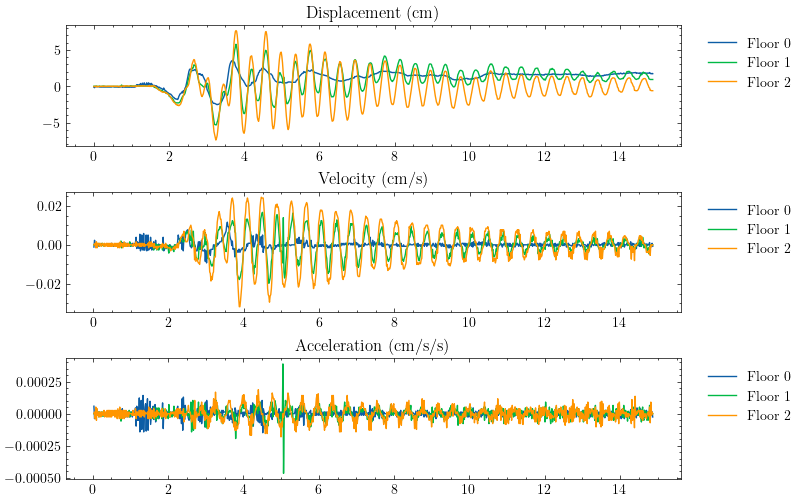

In [ ]:
# Choose a record index (e.g. 1 if sine_1.0_1.0_1.MOV and 8 if northridge_1.MOV)
record_index = 3

plot_and_save(record_index=record_index, scale_factor=SCALE_FACTOR, n_roi=3)

## 3. Analyze Data: System Identification

In [ ]:
import mdof.utilities
from mdof import modes
for record_index in [4,8]:
    print(COLLECTED_DATA[record_index][0:5:4])
    displ = np.loadtxt(OUT_DIR/(f"{record_index}.csv"))
    inputs = displ[:,0].T
    outputs = displ[:,1:].T
    realization = sysid(inputs=inputs, outputs=outputs, order=6)
    mymodes = modal.system_modes(realization, dt=1/60)
    mdof.utilities.print_modes(mymodes)

['sine wave', 'sine_1.0_2.0_1.MOV']
Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC
      0.5003     0.03258    1.0        0.9878     0.9878   
      0.3965     0.0452     1.0        0.9988     0.9988   
Mean Period(s): 0.44842861511178517
Standard Dev(s): 0.05189126654594006
['Northridge EQ', 'northridge_1.MOV']
Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC
      11.02      0.2952     1.0        0.8041     0.8041   
      0.408      -0.00778   1.0        0.9994     0.9994   
      0.3943     0.0124     1.0        0.9995     0.9995   
Mean Period(s): 3.93944129171216
Standard Dev(s): 5.003874119946297


### From a model fitted to Northridge, predict the output of the sine wave.

In [ ]:
# Fit a model to the Northridge data
displ_northridge = np.loadtxt(OUT_DIR/(f"8.csv"))
inputs_northridge = displ_northridge[:,0].T
outputs_northridge = displ_northridge[:,1:].T
realization = sysid(inputs=inputs_northridge, outputs=outputs_northridge, order=6)

In [ ]:
# Predict the output of the sine wave
displ_sine = np.loadtxt(OUT_DIR/(f"4.csv"))
inputs_sine = displ_sine[:,0].T
actual_outputs_sine = displ_sine[:,1:].T
from mdof import predict
estimated_outputs_sine = predict(realization, inputs=inputs_sine)

Text(0.5, 0.98, 'Floor 2 Prediction')

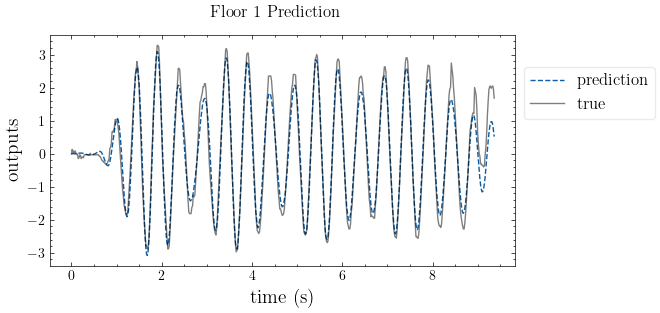

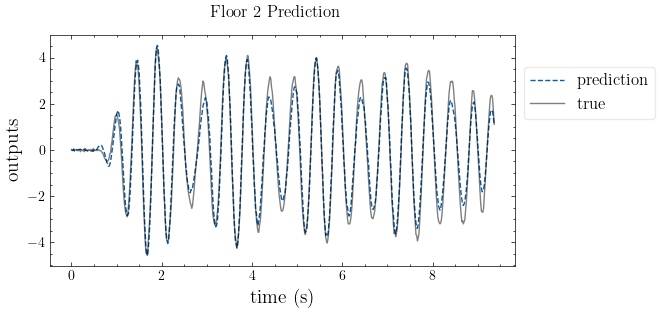

In [ ]:
from mdof.utilities.printing import plot_pred
fig1 = plot_pred(ytrue=actual_outputs_sine[0], models=estimated_outputs_sine[0], t=np.arange(0,(1/60*(estimated_outputs_sine.shape[1])),1/60))
fig1.suptitle('Floor 1 Prediction')
fig2 = plot_pred(ytrue=actual_outputs_sine[1], models=estimated_outputs_sine[1], t=np.arange(0,(1/60*(estimated_outputs_sine.shape[1])),1/60))
fig2.suptitle('Floor 2 Prediction')